In [1]:
import copy, os, gc, tqdm
import numpy as np
import pickle as pkl
from time import time, sleep

from IPython import display
from collections import Counter
from itertools import product, chain, combinations


#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')


import sys
library_path = '../../'
if library_path not in sys.path:
    sys.path.append(library_path)

CIFAR10_DIR = library_path + 'datasets/CIFAR10'
MNIST_DIR   = library_path + 'datasets/MNIST'

from ml.utils import get_CIFAR10_data, get_MNIST_data
from ml.neural_network import Layer, Sequential, Model, Solver
from ml.neural_network.layers import Dense, Dropout, SoftMax, BatchNormalization
from ml.neural_network.nonlinearities import Tanh, ReLU, LeakyReLU, ELU, SoftPlus
from ml.neural_network.regularizers import *
from ml.neural_network.initializers import *
from ml.neural_network.optimizers import *
from ml.neural_network.criterions import MSECriterion, MulticlassLogLoss


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

<a id='toc'></a>
* [1. Modules](#modules)
    * [1.1 Base objects](#base)
        * [1.1.1 Layer](#layer)
        * [1.1.2 Sequential](#seq)
    * [1.2 Helpers](#helpers)
        * [1.2.1 Initializers](#initializers)
        * [1.2.2 Regularizers](#regularizers)
        * [1.2.3 Gradients checker](#grad_checker)
    * [1.3 Layers](#layers)
        * [1.3.1 Dense](#dense)
            * [1.3.1.1 Dense: forward](#dense_forward)
            * [1.3.1.2 Dense: backward](#dense_backward)
        * [1.3.2 Softmax](#softmax)
        * [1.3.3 Dropout](#dropout)
            * [1.3.3.1 Dropout: forward](#dropout_forward)
            * [1.3.3.2 Dropout: backward](#dropout_backward)
        * [1.3.4 BatchNormalization](#bn)
            * [1.3.4.1 BatchNormalization: forward](#bn_forward)
            * [1.3.4.2 BatchNormalization: backward](#bn_backward)
    * [1.4 Nonlinearities](#activations)
    * [1.5 Criterions](#criterions)      
    * [1.6 Model](#model)
    * [1.7 Update rules](#optimizers)
        * [1.7.1 SGD with momentum](#update_sgd_momentum)
        * [1.7.2 RMSProp](#update_rmsprop)
        * [1.7.3 Adam](#update_adam)
    * [1.8 Solver](#solver)
* [2. Fully Connected Network](#fcn)
    * [2.1 Toy example](#toy_example)
        * [2.1.1 Network 1](#toy_example_net1)
        * [2.1.2 Network 2](#toy_example_net2)
    * [X.X Loading datasets](#fcn_datasets)
    * [X.X Checks](#fcn_checks)
        * [X.X.X Initial loss and gradient check](#fcn_initial_checks)
        * [X.X.X Overfitting small data](#fcn_checks_overfit)
    * [X.X Comparison of architectures](#comp_architectures)
        * [X.X.X Comparison](#comparison)
    * [X.X Comparison of update rules](#comp_updates)
    * [X.X Dropout](#comp_dropout)
    * [X.X Batch normalization for deep networks](#fcn_batchnorm_deep)
        * [X.X.X Convergence acceleration](#fcn_batchnorm_conv)
        * [X.X.X Batch normalization and initialization](#fcn_batchnorm_init)
    * [X.X Final model](#fcn_final)
* [3. Convolutional Network](#cnn)

<a id='modules'></a>
# 1. Modules[[toc]](#toc)

<a id='base'></a>
## 1.1 Base objects [[toc]](#toc)

<a id='layer'></a>
### 1.1.1 Layer [[toc]](#toc)

In [100]:
# %load ../../ml/neural_network/layer.py

<a id='seq'></a>
### 1.1.2 Sequential [[toc]](#toc)

In [101]:
# %load ../../ml/neural_network/sequential.py

<a id='helpers'></a>
## 1.2 Helper objects [[toc]](#toc)

<a id='initializers'></a>
### 1.2.1 Initializers [[toc]](#toc)

In [102]:
# %load ../../ml/neural_network/initializers/initializers.py

<a id='regularizers'></a>
### 1.2.2 Regularizers [[toc]](#toc)

In [103]:
# %load ../../ml/neural_network/regularizers/regularizers.py

<a id='grad_checker'></a>
### 1.2.3 Gradients Checker [[toc]](#toc)

In [40]:
import numpy as np
from collections import OrderedDict

def eval_numerical_gradient(f, x, h=1e-5):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        it.iternext() # step to next dimension
    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


class GradientsChecker:
    """
    Это специальный класс предназначенный для вычисления градиентов по параметрам и входам нейронной сети
    """
    def __init__(self, step=1e-5, batch_size=10, verbose=False, seed=0):
        self.step = step
        self.batch_size = batch_size
        self.verbose = verbose
        self.gen = np.random.RandomState(seed)
    def _print(self, msg):
        if self.verbose:
            print(msg)
        
    def _get_X(self, layer, X):
        if X is None:
            input_shape = layer.input_shape
            assert len(input_shape) >= 2
            input_shape = tuple([self.batch_size] + list(input_shape[1:]))
            X = self.gen.normal(size=input_shape)
            self._print('Generated X with shape = {}'.format(X.shape))
        assert isinstance(X, np.ndarray)
        return X
    def _get_y(self, model, X, y):
        batch_size = X.shape[0]
        if y is not None:
            if isinstance(model.criterion, MSECriterion):
                y = self.gen.normal(size=batch_size)
            elif isinstance(model.criterion, MulticlassLogLoss):
                n_classes = model.criterion.n_classes
                y = self.gen.randint(0, n_classes, size=batch_size, dtype=np.int32)
            else:
                assert False, 'Unknown criterion: cannot generate (X, y) pair'
            if self.verbose:
                self._print('Generated y with shape = {}'.format(y.shape))
        assert isinstance(X, np.ndarray)
        assert isinstance(y, np.ndarray)
        assert X.shape[1:] == model.input_shape[1:]
        assert X.shape[0] == y.shape[0]
        return y
    def _get_grad_Y(self, layer, X, grad_Y):
        assert isinstance(layer, Layer)
        assert isinstance(X, np.ndarray)
        output_shape = tuple([X.shape[0]] + list(layer.output_shape[1:]))
        if grad_Y is None:
            grad_Y = self.gen.normal(size=output_shape)
            self._print('Generated grad_Y with shape = {}'.format(grad_Y.shape))
        assert isinstance(grad_Y, np.ndarray)
        assert grad_Y.shape == output_shape
        return grad_Y
        
    def _save_state(self, layer):
        self.saved_params = layer.get_params(copy=True)           # Получить копии параметров сети
        self.saved_grad_params = layer.get_grad_params(copy=True) # Получить копии градиентов параметров сети
    
    def _restore_state(self, layer):
        layer.set_params(self.saved_params)              # Восстановление параметров слоя
        layer.set_grad_params(self.saved_grad_params)    # Восстановление градиентов слоя
        
    def eval_gradients(self, layer, input=None, output=None, params=None, restore_state=False):
        method_name = 'eval_gradients'
        assert isinstance(layer, Layer)
        # Сохранение состояния модели в случае использования внешних параметров
        if restore_state:
            self._save_state(layer)
        # Выставление внешних параметров
        if params is not None: # При оценке градиентов будут использованы указанные в params параметры модели
            layer.set_params(params) # Выставление требуемых параметров
            layer.zero_grad_params() # Обнуление градиентов
            if self.verbose:
                print('{}.{}(...): setting outer parameters'.format(type(self).__name__, method_name))    
        if isinstance(layer, Model):
            self._eval_model_gradients(layer, input, output)
        else:
            self._eval_layer_gradients(layer, input, output)
        if input is None:
            output = None
        # Восстановление состояния модели
        if restore_state:
            self._restore_state(layer)
        
    def _eval_model_gradients(self, model, X=None, y=None):
        """
        Оценивает градиент модели по параметрам.
        
        Внимание: после оценки градиентов модель в общем случае уже не будет находиться в изначальном состоянии,
        хотя и значения параметров и их производных будут возвращены в исходное значение. Как минимум это связано
        с потенциальным вызовом генераторов. Кроме того, в случае BatchNormalization слоя происходит обновление 
        скользящих среднего и дисперсии.
        
        Аргументы:
        - model
        - X
        - y
        Возвращаемое значение:
        -
        """   
        X = self._get_X(model, X)
        y = self._get_y(model, X, y)
        # Функция потерь
        def function(self, *args, **kwargs):
            return model.forward(X, y)
        # Численная оценка градиентов
        self.num_grad_params = OrderedDict()
        for p_name, p_value in model.get_params().items():
            self.num_grad_params[p_name] = eval_numerical_gradient(function, p_value, h=self.step)
        # Аналитическая оценка градиентов
        loss = model.forward(X, y)
        _    = model.backward(X, y)
        self.grad_params = model.get_grad_params(copy=True)
        # Печать относительной ошибки
        for p_name in self.grad_params:
            print('grad_{} error = {}'.format(
                p_name, rel_error(self.num_grad_params[p_name], self.grad_params[p_name])))    

    def _eval_layer_gradients(self, layer, X=None, grad_Y=None):
        X = self._get_X(layer, X)
        grad_Y = self._get_grad_Y(layer, X, grad_Y)
        # Функция нахождения выхода сети
        def function(self, *args, **kwargs):
            return layer.forward(X)
        # Численная оценка градиента по входу
        self.num_grad_input = eval_numerical_gradient_array(function, X, grad_Y, h=self.step)
        # Численная оценка градиентов по параметрам
        self.num_grad_params = OrderedDict()
        for p_name, p_value in layer.get_params().items():
            self.num_grad_params[p_name] = eval_numerical_gradient_array(function, p_value, grad_Y, self.step)
        # Аналитическая оценка градиентов по входу и параметрам
        self.grad_input  = layer.backward(X, grad_Y)
        self.grad_params = layer.get_grad_params(copy=True)
        # Печать относительной ошибки
        for p_name in grad_params:
            print('grad_{} error = {}'.format(
                p_name, rel_error(self.num_grad_params[p_name], self.grad_params[p_name])))
        print('grad_X error = {}'.format(rel_error(self.num_grad_input, self.grad_input)))

In [41]:
def plot_solver_history(history, axarr=None, figsize=(10, 14), colors=None, markers=None):
    if axarr is None:
        _, axarr = plt.subplots(3, 1, figsize=figsize)
    plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}
    if colors is None: 
        colors = {'train': 'r', 'val': 'b'}
    if markers is None:
        markers = {'train': 'o', 'val': '^'}
        
    ax = axarr[0]  
    ax.plot(history['loss_history'], color=colors['train'])
    ax.set_yscale('log')
    ax.set_xlabel('iteration')
    ax.set_ylabel('loss')
    ax.set_title('Training loss vs iteration')
    ax.grid(linestyle='--', alpha=0.5)

    ax = axarr[1]
    for label in ['train', 'val']:
        data = history['{}_loss_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Loss vs epoch')
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=16)

    ax = axarr[2]
    for label in ['train', 'val']:
        data = history['{}_acc_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_xlabel('epoch')
    ax.set_ylabel('training loss')
    ax.set_title('Accuracy vs epoch')
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', fontsize=16)
    plt.tight_layout()
    plt.show()
    return axarr

<a id='layers'></a>
## 1.3 Layers [[toc]](#toc)

<a id='dense'></a>
### 1.3.1 Dense [[toc]](#toc)

In [104]:
# %load ../../ml/neural_network/layers/dense.py

In [6]:
dense = Dense(units=100)
print(dense)
print(dense.initialize({'input_shape': (-1, 20)}))
print(dense)

Dense(?->100)
{'grad_clip': inf, 'debug': False, 'seed': 1, 'dtype': <class 'numpy.float64'>, 'names': {'Dense': 1}, 'input_shape': (-1, 20)}
Dense(20->100)


<a id='dense_forward'></a>
#### 1.3.1.1 Dense: forward [[toc]](#toc)

In [7]:
# Test the affine_forward function
batch_size = 2
input_size = 120
output_size = 3

W = np.linspace(-0.2, 0.3, num=input_size * output_size).reshape(input_size, output_size) # [360] - > [120, 3]
b = np.linspace(-0.3, 0.1, num=output_size)
X = np.linspace(-0.1, 0.5, num=batch_size * input_size).reshape(batch_size, input_size) # [2, 120]

dense = Dense(output_size, W_init=W, b_init=b)
dense.initialize({'input_shape': (-1, 120)})

output = dense.forward(X)
correct_output = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                           [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(output, correct_output))

Testing affine_forward function:
difference:  9.7698488884e-10


<a id='dense_backward'></a>
#### 1.3.1.2 Dense: backward [[toc]](#toc)

In [10]:
# Test the affine_backward function
np.random.seed(231)
dtype = np.float64
X = np.random.randn(10, 6).astype(dtype)
W = np.random.randn(6, 5).astype(dtype)
b = np.random.randn(5).astype(dtype)
grad_Y = np.random.randn(10, 5).astype(dtype)
print('X.shape =', X.shape)
print('W.shape =', W.shape)
print('b.shape =', b.shape)

dense = Dense(5, W_init=W, b_init=b)
dense.initialize({'input_shape': X.shape})
grad_checker = GradientsChecker(verbose=True)
grad_checker.eval_gradients(dense, X, grad_Y)

X.shape = (10, 6)
W.shape = (6, 5)
b.shape = (5,)
grad_Dense0:W error = 2.1752635504596857e-10
grad_Dense0:b error = 7.736978834487815e-12
grad_X error: 1.0908199508708189e-10


<a id='softmax'></a>
### 1.3.2 Softmax [[toc]](#toc)

In [105]:
# %load ../../ml/neural_network/layers/softmax.py

In [11]:
softmax = SoftMax()
softmax.initialize({'input_shape': (10, 25)})
grad_checker = GradientsChecker(verbose=True)
grad_checker.eval_gradients(softmax)

Generated X with shape = (10, 25)
Generated grad_Y with shape = (10, 25)
grad_X error: 4.920997221035878e-06


<a id='dropout'></a>
### 1.3.3 Dropout [[toc]](#toc)
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [106]:
# %load ../../ml/neural_network/layers/dropout.py

In [12]:
seed = 15; p = 0.5
dropout = Dropout(p)
dropout.initialize({'input_shape': (10, 25), 'seed': seed})
def callback():
    dropout.gen = np.random.RandomState(seed)
dropout.set_forward_exit_call(callback)
grad_checker = GradientsChecker(verbose=True, seed=seed + 1)
grad_checker.eval_gradients(dropout)

Generated X with shape = (10, 25)
Generated grad_Y with shape = (10, 25)
grad_X error: 3.2756305172299518e-12


<a id='dropout_forward'></a>
#### Dropout: forward [[toc]](#toc)

In [19]:
np.random.seed(231)
X = np.random.randn(500, 500) + 10
dropout = Dropout(0)
dropout.initialize({'input_shape': (10, 25)})

for p in [0.3, 0.6, 0.75]:
    dropout.p = p
    dropout.train()
    out      = dropout.forward(X)
    dropout.evaluate()
    out_test = dropout.forward(X)
    
    print('Running tests with p = ', p)
    print('Mean of input: ', X.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.0002078785
Mean of train-time output:  7.00311276126
Mean of test-time output:  7.00014551493
Fraction of train-time output set to zero:  0.299804
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0002078785
Mean of train-time output:  3.98521948532
Mean of test-time output:  4.00008315139
Fraction of train-time output set to zero:  0.60156
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.0002078785
Mean of train-time output:  2.52026295957
Mean of test-time output:  2.50005196962
Fraction of train-time output set to zero:  0.748108
Fraction of test-time output set to zero:  0.0



<a id='dropout_backward'></a>
#### Dropout: backward [[toc]](#toc)

In [13]:
np.random.seed(231)
X = np.random.randn(5, 5) + 10
grad_Y = np.random.randn(*X.shape)

dropout = Dropout(0.8)
# The code below resets state of the dropout layer after each forward propagation
forward_callback = lambda: dropout.initialize({'input_shape': X.shape})
dropout.set_forward_exit_call(forward_callback)
forward_callback()

grad_checker = GradientsChecker(verbose=True)
grad_checker.eval_gradients(dropout, X, grad_Y)

grad_X error: 1.8928932119122836e-11


<a id='bn'></a>
### 1.3.4 BatchNormalization [[toc]](#toc)
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was recently proposed by [3].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [107]:
# %load ../../ml/neural_network/layers/batch_normalization.py

In [8]:
bn = BatchNormalization()
bn.initialize({'input_shape': (10, 25)})
grad_checker = GradientsChecker(verbose=True, seed=6)
grad_checker.eval_gradients(bn)

Generated X with shape = (10, 25)
Generated grad_Y with shape = (10, 25)
grad_BatchNormalization0:gamma error = 4.025790228088049e-10
grad_BatchNormalization0:beta error = 7.30563027694689e-10
grad_X error: 1.0178321374596851e-09


<a id='bn_forward'></a>
#### 1.3.4.1 Batch Normalization: forward [[toc]](#toc)

In [10]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

bn = BatchNormalization()
print(bn.initialize({'input_shape': a.shape}))

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm = bn.forward(a)
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
bn.gamma = gamma
bn.beta = beta
a_norm  = bn.forward(a)
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

{'grad_clip': inf, 'debug': False, 'seed': 0, 'dtype': <class 'numpy.float64'>, 'names': {'BatchNormalization': 1}, 'input_shape': (200, 3)}
Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [ 27.18502186  34.21455511  37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [  1.77635684e-17  -5.32907052e-17   2.13717932e-17]
  std:  [ 0.99999999  1.          1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999999]


In [11]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn = BatchNormalization()
bn.initialize({'input_shape': a.shape})
bn.gamma = np.ones(D3)
bn.beta = np.zeros(D3)
bn.train()

for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    a_norm = bn.forward(a)

bn.evaluate()
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm = bn.forward(a)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [ 1.01531428  1.01238373  0.97819988]


<a id='bn_backward'></a>
#### 1.3.4.2 Batch Normalization: backward  [[toc](#toc)]

In [12]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 100, 5
X      = 5 * np.random.randn(N, D) + 12
gamma  = np.random.randn(D)
beta   = np.random.randn(D)
grad_Y = np.random.randn(N, D)
grad_checker = GradientsChecker(step=1e-5)
bn = BatchNormalization(name='bn')
bn.initialize({'input_shape': X.shape})
grad_checker.eval_gradients(bn, X, grad_Y, params={'bn:gamma': gamma, 'bn:beta': beta})

grad_bn:gamma error = 3.8696505510766274e-11
grad_bn:beta error = 3.583810426671133e-11
grad_X error: 5.329833567756457e-07


<a id='activations'></a>
## 1.4 Activations [[toc]](#toc)

<a id='tanh'></a>
* **Tanh**. 
* **ReLU**. Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**). 
* **LeakyReLU**. Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Experiment with slope. 
* **ELU**. Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.
* **SoftPlus**. Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [ ]:
# %load ../../ml/neural_network/nonlinearities.py

In [13]:
input_shape = (40, 50)
layers = [Tanh(), ReLU(), LeakyReLU(), ELU(), SoftPlus()]
grad_checker = GradientsChecker(seed=1937)
for layer in layers:
    print(layer)
    layer.initialize({'input_shape': input_shape})
    grad_checker.eval_gradients(layer)

Tanh
grad_X error: 1.0462891259155891e-06
ReLU
grad_X error: 3.2756267771145447e-12
LeakyReLU
grad_X error: 8.595445066707563e-12
ELU
grad_X error: 4.479414434183517e-11
SoftPlus
grad_X error: 9.930782772946046e-11


<a id='criterions'></a>
## 1.5 Criterions [[toc]](#toc)
## TODO add other criterions

* **MSE**. The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
* **MulticlassLogLoss**. You task is to implement the **MulticlassLogLoss**. It should implement [multiclass log loss](https://www.kaggle.com/wiki/MultiClassLogLoss). Nevertheless there is a sum over `y` (target) in that formula,  remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. 

In [113]:
# %load ../../ml/neural_network/criterions.py

You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `ml/neural_network/cs231n/second/layers.py`.

You can make sure that the implementations are correct by running the following:

In [ ]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

<a id='model'></a>
## 1.6 Model [[toc]](#toc)

In [6]:
# %load ../../ml/neural_network/model.py

<a id='optimizers'></a>
## 1.7 Update rules [[toc]](#toc)

In [36]:
# %load ../../ml/neural_network/optimizers.py

<a id='update_sgd_momentum'></a>
### 1.7.1 SGD + Momentum [[toc](#toc)]
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent. 

Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [14]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N * D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N * D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N * D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ',   rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


<a id='update_rmsprop'></a>
### 1.7.2 RMSProp and Adam [[toc](#toc)]
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [15]:
# Test RMSProp implementation; you should see errors less than 1e-7

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [16]:
# Test Adam implementation; you should see errors around 1e-7 or less

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


<a id='solver'></a>
## 1.8 Solver [[toc]](#toc)

In [7]:
# %load ../../ml/neural_network/solver.py

<a id='fcn'></a>
# 2. Fully Connected Network [[toc]](#toc)

Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `ml/neural_network/cs231n/second/fcn.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

<a id='toy_example'></a>
## 2.1 Toy example [[toc]](#toc)

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers.

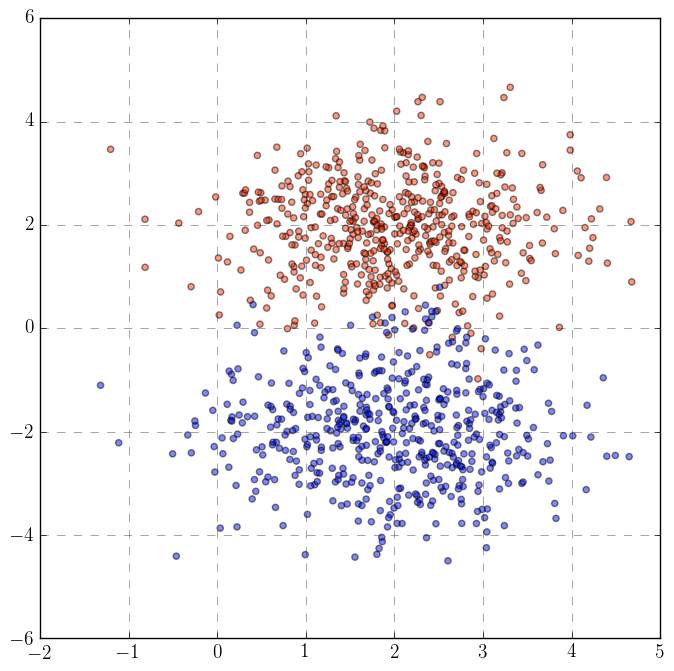

In [4]:
# Generate some data
N = 500
np.random.seed(10)

X_train1 = np.random.randn(N, 2) + np.array([2, 2])
X_train2 = np.random.randn(N, 2) + np.array([2, -2])
X_train = np.vstack([X_train1, X_train2])
y_train = np.concatenate([np.ones(N), np.zeros(N)]).astype(np.int32)

X_val1 = np.random.randn(N, 2) + np.array([2, 2])
X_val2 = np.random.randn(N, 2) + np.array([2, -3])
X_val = np.vstack([X_val1, X_val2])
y_val  = np.concatenate([np.ones(N), np.zeros(N)]).astype(np.int32)

plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='jet', vmin=-0.2, vmax=1.2, edgecolors='k', alpha=0.5)
plt.grid(linestyle='--', alpha=0.5)

data = {'X_train': X_train, 'y_train': y_train,
        'X_val':   X_val,  'y_val': y_val}

Define a **logistic regression** for debugging. 

<a id='toy1'></a>
### 2.1.1 Network 1[[toc]](#toc)

#### Full dataset training 
Initially batch size set to 1000 to ensure that every step lowers the loss.

In [17]:
net = Sequential([Dense(2, W_reg=L2Regularizer(0.01)), SoftMax()])
criterion = MulticlassLogLoss()
model = Model(net, criterion)

optim_config = {'update_rule': 'sgd', 'learning_rate': 0.1, 'learning_rate_decay': 1.0, 'momentum': 0.1}
solver = Solver(model=model, data=data, optim_config=optim_config, verbose=False,
                n_epochs=100, batch_size=1000, print_every_epoch=10, seed=0)
model = solver.train()
plot_solver_history(solver.history, figsize=(10, 12));
print('Final val loss:   ', solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

NameError: name 'data' is not defined

#### Minibatch training

Dense(2->2)->SoftMax->[MulticlassLogLoss]


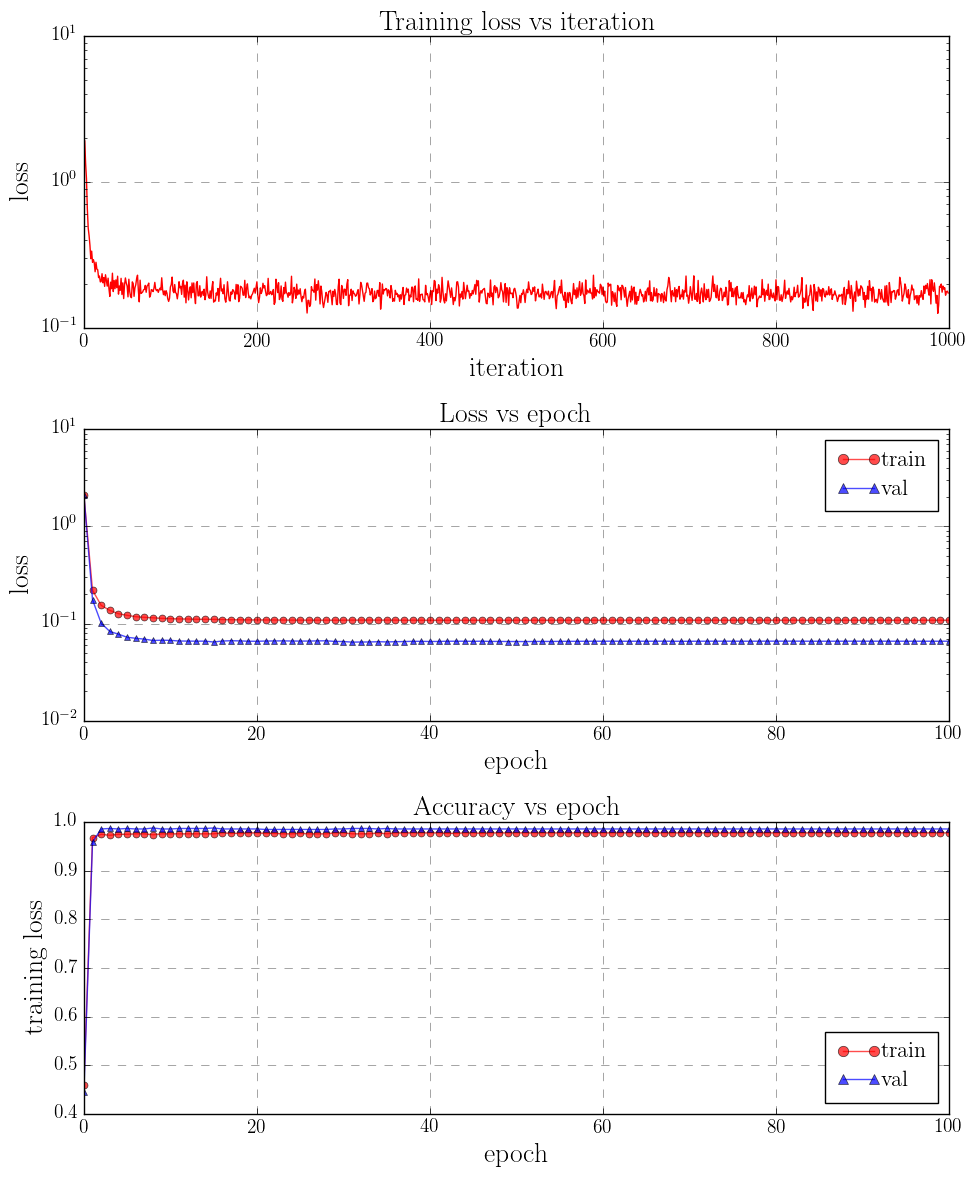

Final val loss:    0.06572932973763027
Final val accuracy: 0.986


In [19]:
net = Sequential([Dense(2, W_reg=L2Regularizer(0.1)), SoftMax()])
criterion = MulticlassLogLoss()
model = Model(net, criterion)

optim_config = {'update_rule': 'sgd',  'learning_rate': 0.1, 'learning_rate_decay': 0.95, 'momentum': 0.9}
solver = Solver(model=model, data=data, optim_config=optim_config, 
                verbose=False, n_epochs=100, batch_size=100, seed=0)
print(model)
model = solver.train()
plot_solver_history(solver.history, figsize=(10, 12));
print('Final val loss:   ', solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

<a id='toy_example_net2'></a>
### 2.1.2 Network 2 [[toc]](#toc)

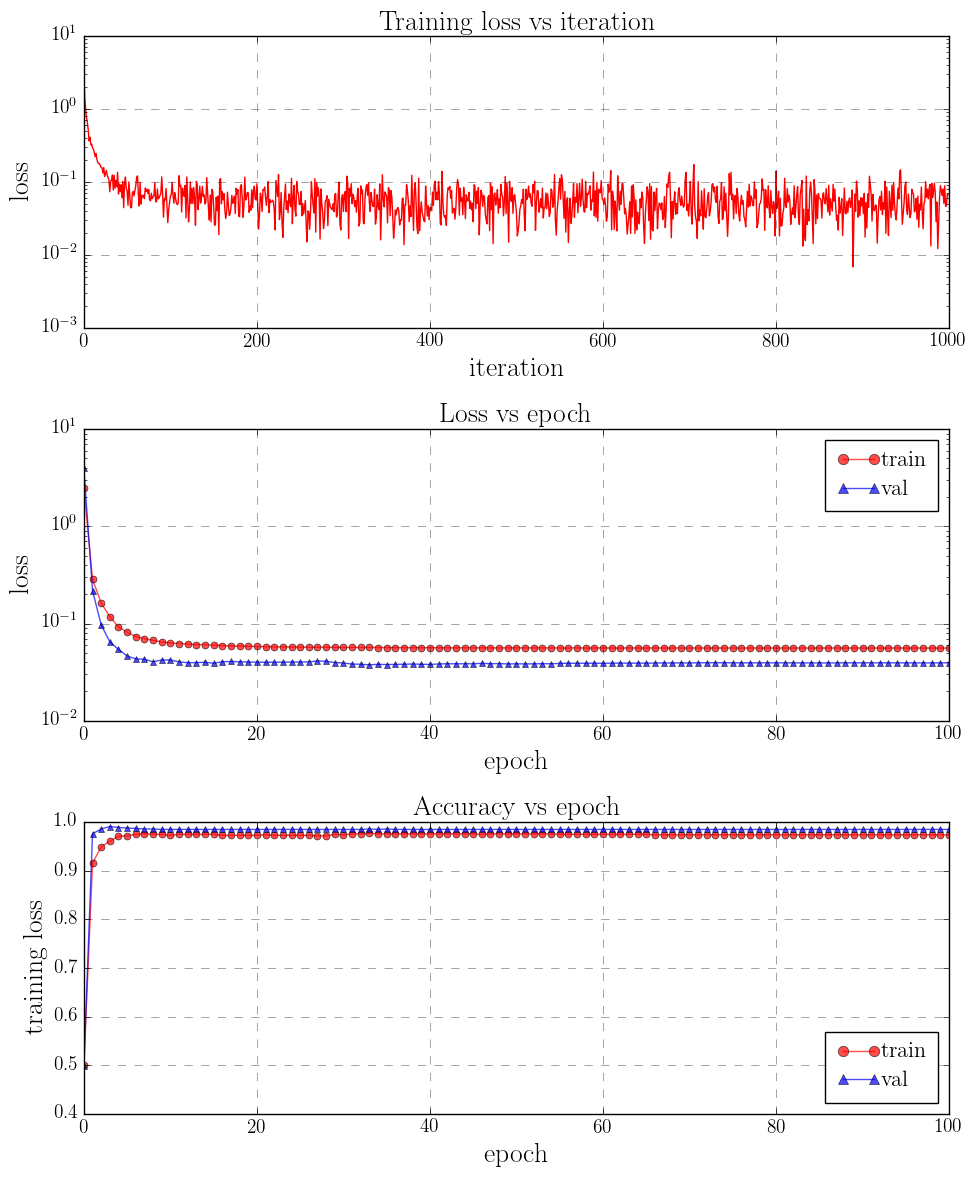

Final val loss:    0.0393622546418386
Final val accuracy: 0.985


In [18]:
net = Sequential([Dense(4), ReLU(), Dense(2), SoftMax()])
criterion = MulticlassLogLoss()
model = Model(net, criterion)

optim_config = {'update_rule':   'sgd', 'learning_rate':  0.1, 'learning_rate_decay': 0.95, 'momentum': 0.1}
solver = Solver(model=model, data=data, model_config={'grad_clip': np.inf}, optim_config=optim_config, 
                n_epochs=100, batch_size=100, print_every_epoch=None, print_every_iter=None, seed=0)
model = solver.train()
plot_solver_history(solver.history, figsize=(10, 12));
print('Final val loss:   ', solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

<a id='fcn_datasets'></a>
## X.X Loading datasets [[toc]](#toc)

In [2]:
DATASET = 'cifar'
if DATASET == 'cifar':
    data = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                             ravel=True, substract_mean=True, random_state=1, normalize_by=255.0, verbose=True)
elif DATASET == 'mnist':
    data = get_MNIST_data(train_size=69000, val_size=1000, substract_mean=True, normalize_by=255.0, 
                          verbose=True, random_state=1, mnist_dir=MNIST_DIR)
else: 
    assert False, 'Unknown dataset'

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 3072)
Training labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


<a id='digits_test_run'></a>
## X.X Test run [[toc]](#toc)

In [267]:
net = Sequential()
net.add(Dense(10))
net.add(SoftMax())
criterion = MulticlassLogLoss()
model = Model(net, criterion)

optim_config = {'update_rule':        'adam', 
                'learning_rate':       0.001,
                'learning_rate_decay': 0.995,
                'momentum':            0.1}
solver = Solver(model=model, data=data, optim_config=optim_config, verbose=False,
                n_epochs=100, batch_size=100, print_every_epoch=5)
print(model)
model = solver.train()
plot_solver_history(solver.history);
print('Final val loss:   ',  solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

Dense(784->10)->SoftMax->[MulticlassLogLoss]
(Epoch 5/100) train acc: 0.92; val acc: 0.92, train loss: 0.2722; val loss: 0.2864


KeyboardInterrupt: 

### Test run CIFAR-10
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `ml/neural_network/cs231n/second/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

<a id='digits'></a>
# 3. Digits classification [[toc]](#toc)
We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures.

<a id='fcn_checks'></a>
## X.X Checks [[toc]](#toc)

<a id='fcn_initial_checks'></a>
### X.X.X Initial loss and gradient check [[toc](#toc)]

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs2312n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the flag `use_batchnorm` is `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. If you decide to do so, do it in the file `cs231n/classifiers/fc_net.py`.

In [52]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for use_batchnorm, l2_reg in product([False, True], [0, 3.14]):
    print('Running check with l2_reg = ', l2_reg)
    W_reg = L2Regularizer(l2_reg)
    if use_batchnorm:
        model = Model(Sequential([Dense(H1, W_reg=W_reg), ReLU(), BatchNormalization(name='bn1'), 
                                  Dense(H2, W_reg=W_reg), ReLU(), BatchNormalization(name='bn2'),
                                  Dense(C,  W_reg=W_reg), SoftMax()]), MulticlassLogLoss())
    else:
        model = Model(Sequential([Dense(H1, W_reg=W_reg), ReLU(),
                                  Dense(H2, W_reg=W_reg), ReLU(),
                                  Dense(C,  W_reg=W_reg), SoftMax()]), MulticlassLogLoss())
    model.compile(input_shape=X.shape)
    print(model)
    loss = model.forward(X, y)
    print('Initial loss: ', loss)
    grad_checker = GradientsChecker(seed=123, step=1e-5)
    grad_checker.eval_gradients(model, X, y)
    print()

Running check with l2_reg =  0
Dense(15->20)->ReLU->Dense(20->30)->ReLU->Dense(30->10)->SoftMax->[MulticlassLogLoss]
Initial loss:  2.47162406851
grad_Dense0:W error = 2.4611325222362036e-08
grad_Dense0:b error = 5.364700376662644e-10
grad_Dense1:W error = 9.831112706724674e-08
grad_Dense1:b error = 1.2498272972491581e-09
grad_Dense2:W error = 5.771673727103205e-08
grad_Dense2:b error = 1.598902179306298e-10

Running check with l2_reg =  3.14
Dense(15->20)->ReLU->Dense(20->30)->ReLU->Dense(30->10)->SoftMax->[MulticlassLogLoss]
Initial loss:  98.311819854
grad_Dense0:W error = 2.3104581359723222e-08
grad_Dense0:b error = 1.6905763658940493e-08
grad_Dense1:W error = 3.319034309525178e-08
grad_Dense1:b error = 3.0425923711731527e-08
grad_Dense2:W error = 2.397890125090188e-07
grad_Dense2:b error = 4.336938595976873e-09

Running check with l2_reg =  0
Dense(15->20)->ReLU->BatchNormalization->Dense(20->30)->ReLU->BatchNormalization->Dense(30->10)->SoftMax->[MulticlassLogLoss]
Initial loss: 

<a id='fcn_checks_overfit'></a>
### X.X.X Overfitting small data [[toc]](#toc)

As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

In [3]:
# TODO: Use a three-layer Net to overfit 50 training examples.
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train].reshape((num_train, -1)),
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'].reshape((data['X_val'].shape[0], -1)),
  'y_val':   data['y_val'],
}

model = Model(Sequential([Dense(100), ReLU(), Dense(100), ReLU(), Dense(10), SoftMax()]), MulticlassLogLoss())
optim_config = {'update_rule': 'sgd', 'learning_rate': 0.1}
solver = Solver(model, small_data, optim_config=optim_config, 
                n_epochs=20, batch_size=25, seed=0,
                verbose=False, print_every_epoch=1)
print(model)
model = solver.train()

Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/20) train acc: 0.44; val acc: 0.15, train loss: 2.162; val loss: 2.281
(Epoch 2/20) train acc: 0.66; val acc: 0.18, train loss: 2.038; val loss: 2.26
(Epoch 3/20) train acc: 0.62; val acc: 0.19, train loss: 1.91; val loss: 2.248
(Epoch 4/20) train acc: 0.66; val acc: 0.21, train loss: 1.763; val loss: 2.219
(Epoch 5/20) train acc: 0.72; val acc: 0.22, train loss: 1.631; val loss: 2.188
(Epoch 6/20) train acc: 0.72; val acc: 0.23, train loss: 1.5; val loss: 2.164
(Epoch 7/20) train acc: 0.74; val acc: 0.21, train loss: 1.375; val loss: 2.152
(Epoch 8/20) train acc: 0.72; val acc: 0.22, train loss: 1.253; val loss: 2.159
(Epoch 9/20) train acc: 0.74; val acc: 0.23, train loss: 1.159; val loss: 2.149
(Epoch 10/20) train acc: 0.78; val acc: 0.22, train loss: 1.045; val loss: 2.142
(Epoch 11/20) train acc: 0.8; val acc: 0.23, train loss: 0.9588; val loss: 2.149
(Epoch 12/20) train acc: 0.82;

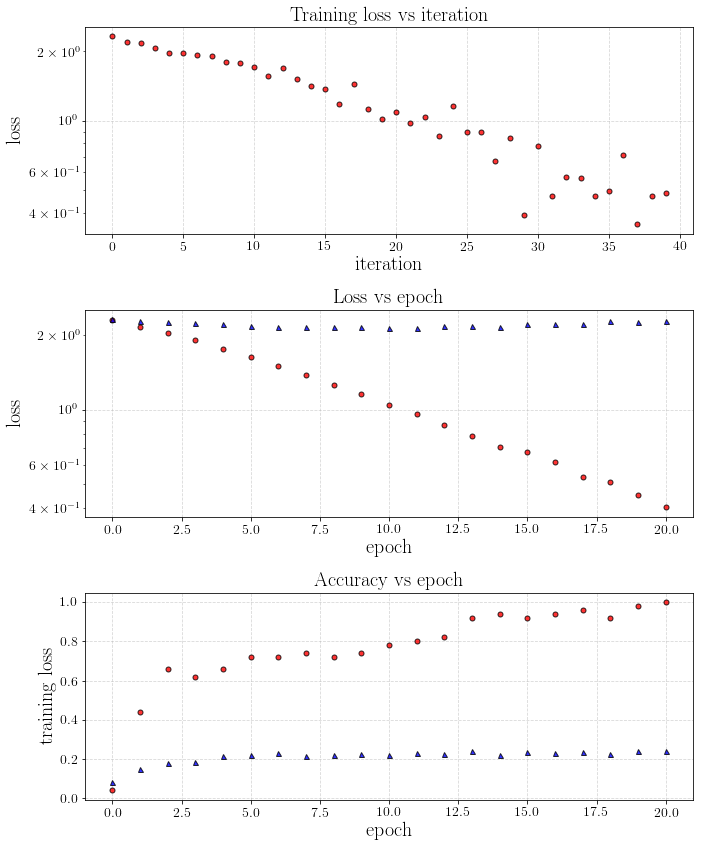

In [4]:
f, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax = axarr[0]
ax.plot(solver.loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[1]
ax.plot(solver.train_loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_loss_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_acc_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [5]:
# TODO: Use a five-layer Net to overfit 50 training examples.
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train].reshape((num_train, -1)),
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'].reshape((data['X_val'].shape[0], -1)),
  'y_val':   data['y_val'],
}

model = Model(Sequential([Dense(100), ReLU(), 
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(10),  SoftMax()]), MulticlassLogLoss())
optim_config = {'update_rule': 'sgd', 'learning_rate': 0.3, 'learning_rate_decay': 0.95}
solver = Solver(model, small_data, optim_config=optim_config, 
                n_epochs=20, batch_size=25, seed=0,
                verbose=False, print_every_epoch=1)
print(model)
model = solver.train()

Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/20) train acc: 0.4; val acc: 0.15, train loss: 2.236; val loss: 2.297
(Epoch 2/20) train acc: 0.44; val acc: 0.12, train loss: 2.17; val loss: 2.295
(Epoch 3/20) train acc: 0.52; val acc: 0.12, train loss: 2.075; val loss: 2.295
(Epoch 4/20) train acc: 0.38; val acc: 0.12, train loss: 1.916; val loss: 2.304
(Epoch 5/20) train acc: 0.54; val acc: 0.19, train loss: 1.783; val loss: 2.284
(Epoch 6/20) train acc: 0.46; val acc: 0.17, train loss: 1.643; val loss: 2.338
(Epoch 7/20) train acc: 0.52; val acc: 0.18, train loss: 1.623; val loss: 2.35
(Epoch 8/20) train acc: 0.62; val acc: 0.2, train loss: 1.286; val loss: 2.364
(Epoch 9/20) train acc: 0.68; val acc: 0.18, train loss: 1.295; val loss: 2.373
(Epoch 10/20) train acc: 0.6; val acc: 0.2, train loss: 1.175; val loss: 2.363
(Epoch 11/20) train acc: 0.8; val acc: 0.19, train loss: 0.865; val

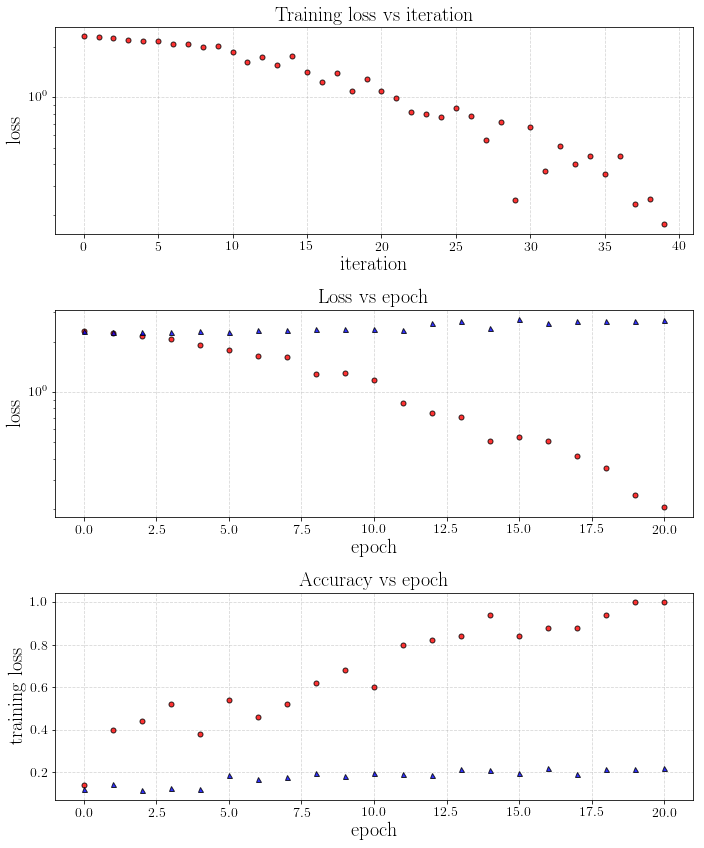

In [6]:
f, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax = axarr[0]
ax.plot(solver.loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[1]
ax.plot(solver.train_loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_loss_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_acc_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

#### Answer:
[FILL THIS IN]

<a id='comp_architectures'></a>
## X.X Comparison of architectures [[toc]](#toc)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` between `Dense` layer and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

<a id='test_net_gen'></a>
### 3.2.1 Generator of test network<sup>[toc](#toc)</sup>

In [7]:
ACTIVATIONS = {
    "Tanh": Tanh,
    "ReLU": ReLU,
    "LeakyReLU": LeakyReLU,
    "ELU": ELU,
    "SoftPlus": SoftPlus 
}

def create_model(activation, hidden_sizes, use_dropout=False, use_batchnorm=False, **params):
    net = Sequential()
    for hidden_size in hidden_sizes[:-1]:
        net.add(Dense(hidden_size))
        net.add(ACTIVATIONS[activation]())
        if use_batchnorm: net.add(BatchNormalization())
        if use_dropout: net.add(Dropout(params['dropout_prob']))
    net.add(Dense(hidden_sizes[-1]))
    net.add(SoftMax())
    criterion = MulticlassLogLoss()
    return Model(net, criterion)
    
model = create_model('Tanh', [100, 10], False, True, dropout_prob=0.1)
model = model.compile(input_shape=data['X_train'].shape, dtype=np.float64, seed=11)
print(model)

Dense(3072->100)->Tanh->BatchNormalization->Dense(100->10)->SoftMax->[MulticlassLogLoss]


<a id='comparison'></a>
### 3.2.2 Comparison<sup>[toc](#toc)</sup>

In [8]:
results_filename = 'comparison_architecture_{}.pkl'.format(DATASET)
if os.path.isfile(results_filename):
    RESULTS = pkl.load(open(results_filename, 'rb'))
    print('Already calculated for:')
    for key in RESULTS:
        activation, use_batchnorm = key
        print('\tactivation = {}, use_batchnorm = {}'.format(activation, use_batchnorm))
else:
    RESULTS = {}

Already calculated for:
	activation = ReLU, use_batchnorm = False
	activation = Tanh, use_batchnorm = True
	activation = LeakyReLU, use_batchnorm = False
	activation = Tanh, use_batchnorm = False
	activation = LeakyReLU, use_batchnorm = True
	activation = ELU, use_batchnorm = False
	activation = ELU, use_batchnorm = True
	activation = ReLU, use_batchnorm = True


In [10]:
optim_config = {'update_rule':        'adam', 
                'momentum':            0.5,
                'learning_rate_decay': 0.975}
for activation, use_batchnorm in product(['Tanh', 'ReLU', 'LeakyReLU', 'ELU', 'SoftPlus'], [False, True]):
    print('activation = {}, use_batchnorm = {}'.format(activation, use_batchnorm))
    if (activation, use_batchnorm) in RESULTS:
        #print('Already calculated for {}'.format(activation, use_batchnorm))
        continue
    model = create_model(activation, [100, 100, 10], use_batchnorm=use_batchnorm)
    solver = Solver(model, data, model_config={'debug': True}, optim_config=optim_config, n_epochs=10, 
                    batch_size=100, print_every_epoch=1, verbose=False, seed=11)
    print(model)
    solver.train()
    RESULTS[(activation, use_batchnorm)] = solver.history
    pkl.dump(RESULTS, open(results_filename, 'wb'))
    print('\n\n')

activation = Tanh, use_batchnorm = False
activation = Tanh, use_batchnorm = True
activation = ReLU, use_batchnorm = False
activation = ReLU, use_batchnorm = True
activation = LeakyReLU, use_batchnorm = False
activation = LeakyReLU, use_batchnorm = True
activation = ELU, use_batchnorm = False
activation = ELU, use_batchnorm = True
activation = SoftPlus, use_batchnorm = False
Dense(3072->100)->SoftPlus->Dense(100->100)->SoftPlus->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/10) train acc: 0.47; val acc: 0.43, train loss: 1.51; val loss: 1.608
(Epoch 2/10) train acc: 0.5; val acc: 0.45, train loss: 1.414; val loss: 1.58
(Epoch 3/10) train acc: 0.53; val acc: 0.47, train loss: 1.328; val loss: 1.519
(Epoch 4/10) train acc: 0.57; val acc: 0.49, train loss: 1.246; val loss: 1.455
(Epoch 5/10) train acc: 0.58; val acc: 0.48, train loss: 1.196; val loss: 1.482
(Epoch 6/10) train acc: 0.59; val acc: 0.5, train loss: 1.156; val loss: 1.436
(Epoch 7/10) train acc: 0.61; val acc: 0.51, tr

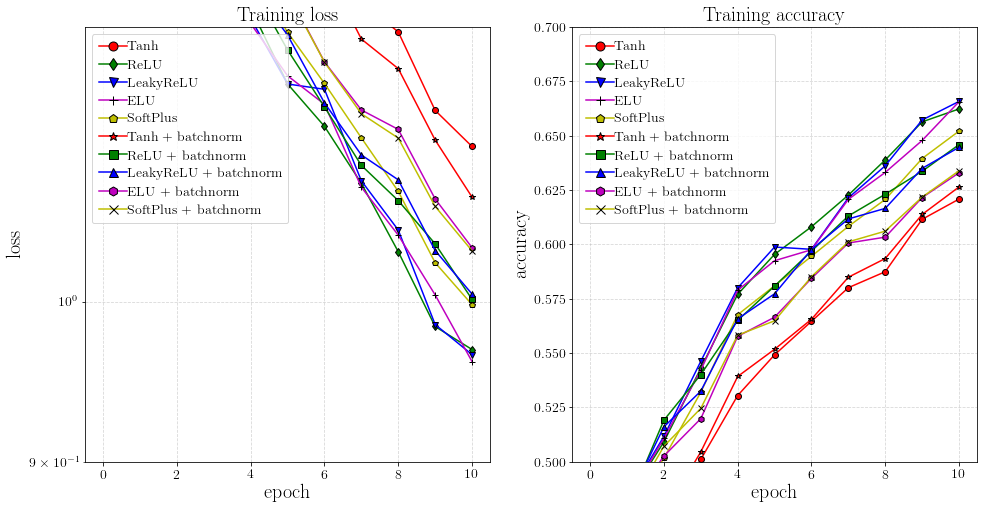

In [21]:
f, axarr = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
results = pkl.load(open(results_filename, 'rb'))
markers = ['o', 'd', 'v', '+', 'p', '*', 's', '^', 'h', 'x']
colors  = ['r', 'g', 'b', 'm', 'y', 'k']
for i, (use_batchnorm, activation) in enumerate(product([False, True], 
        ['Tanh', 'ReLU', 'LeakyReLU', 'ELU', 'SoftPlus'])):
    if use_batchnorm: label = activation + ' + batchnorm'
    else: label = activation
    axarr[0].plot(results[(activation, use_batchnorm)]['train_loss_history'], markeredgecolor='k',
             label=label, marker=markers[i], color=colors[i % 5], ms=6)
    axarr[0].set_ylim([0.9, 1.2])
    axarr[0].legend(loc='upper left')
    axarr[0].set_ylabel('loss')
    axarr[0].set_xlabel('#epoch')
    axarr[0].set_title('Training loss')
    axarr[0].set_yscale('log')
    axarr[0].grid(which='both', alpha=0.5, linestyle='--');
    axarr[1].plot(results[(activation, use_batchnorm)]['train_acc_history'], markeredgecolor='k',
             label=label, marker=markers[i], color=colors[i % 5], ms=6)
    axarr[1].set_ylim([0.5, 0.7])
    axarr[1].legend(loc='upper left')
    axarr[1].set_ylabel('accuracy')
    axarr[1].set_xlabel('#epoch')
    axarr[1].set_title('Training accuracy') 
    axarr[1].grid(which='both', alpha=0.5, linestyle='--');

#### Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

#### Answer

According to the obtained results, the best activations fucntions (at least for the considered task) are ReLU and LeakyReLU. They results in much the lower loss in comparison with the other activations. However, Tanh, ELU and SoftPlus are also not so bad: after 100 iteration they converge to the loss having almost the same accuracy (though the loss itself is almost 2 magnitutes higher than that of the ReLU and LeakyReLU activations).  

As for the **mean substraction**, generally it results learning quality degradation. In case of ReLU, LeakyReLU and ELU, the usage of mean substraction even results in the model divergance. It is due to the too high values in exponents inside the model. The destractive behavior of the mean substraction seems to be a result of the nature of the ReLU, LeakyReLU and ELU activations. Every time the mean substraction is used, it basically switchses off all layer neurons with output values lower than 0. In case of uniform neuron values distribution, approximately the half the output neuron values falls lower than 0 and do not activates. The gradient may show, that some of these neurons should be activated, and the model tries to increase their values. But every time some neurons gets activated, some of them gets deactivated and the process of increasing neuron values continues. Eventually, it can result in the overflow and the model divergance.

The situation about mean substraction can be significantly improved by introducing scaling $\gamma$ and shift $\beta$ parameters.

<a id='comp_updates'></a>
## X.X Comparison of update rules [[toc]](#toc)

In [235]:
recalculate = True # If true, all update rules are run again
calculated_ = False
results_filename = 'update_rules_comparison.pkl'
if (not recalculate) & os.path.isfile(filename):
    RESULTS = pkl.load(open(results_filename, 'rb'))
    calculated_ = True
    print('Already calculated')
else:
    RESULTS = {}

In [236]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train].reshape((num_train, -1)),
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'].reshape((data['X_val'].shape[0], -1)),
  'y_val':   data['y_val'],
}

optim_configs = {'sgd':          {'learning_rate': 1e-2},
                 'sgd_momentum': {'learning_rate': 1e-2, 'momentum': 0.9},
                 'rmsprop':      {'learning_rate': 1e-3, 'decay_rate': 0.99},
                 'adam':         {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999}}
for update_rule, config in optim_configs.items():
    config['learning_rate_decay'] = 1.0
    config['update_rule'] = update_rule

#model_config = {'debug': True}
model_config = {}
    
if (not calculated_) or recalculate:
    print('STARTING CALCULATIONS:')
    for update_rule in ['sgd', 'sgd_momentum', 'rmsprop', 'adam']:
        print('\trunning with: ', update_rule)
        
        net = Sequential([Dense(100), ReLU(), 
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(10),  SoftMax()])
        criterion = MulticlassLogLoss()
        model = Model(net, criterion)
        
        solver = Solver(model, small_data, model_config=model_config, optim_config=optim_configs[update_rule],
                        n_epochs=50, batch_size=100, print_every_epoch=1, seed=123)
        print(model)
        solver.train()
        RESULTS[update_rule] = solver.history
        print()
        pkl.dump(RESULTS, open(results_filename, 'wb'))
else:
    print('Already calculated')

STARTING CALCULATIONS:
	running with:  sgd
Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/50) train acc: 0.15; val acc: 0.15, train loss: 2.293; val loss: 2.294
(Epoch 2/50) train acc: 0.17; val acc: 0.16, train loss: 2.282; val loss: 2.285
(Epoch 3/50) train acc: 0.18; val acc: 0.17, train loss: 2.27; val loss: 2.274
(Epoch 4/50) train acc: 0.21; val acc: 0.18, train loss: 2.255; val loss: 2.26
(Epoch 5/50) train acc: 0.23; val acc: 0.2, train loss: 2.238; val loss: 2.244
(Epoch 6/50) train acc: 0.25; val acc: 0.23, train loss: 2.22; val loss: 2.227
(Epoch 7/50) train acc: 0.25; val acc: 0.24, train loss: 2.201; val loss: 2.208
(Epoch 8/50) train acc: 0.26; val acc: 0.23, train loss: 2.181; val loss: 2.19
(Epoch 9/50) train acc: 0.26; val acc: 0.24, train loss: 2.16; val loss: 2.17
(Epoch 10/50) train acc: 0.27; val acc: 0.24, train loss: 2.138; val loss: 2.15
(Epoch 11/50) train acc: 0

(Epoch 48/50) train acc: 0.96; val acc: 0.38, train loss: 0.1407; val loss: 5.113
(Epoch 49/50) train acc: 0.95; val acc: 0.35, train loss: 0.1482; val loss: 4.873
(Epoch 50/50) train acc: 0.98; val acc: 0.38, train loss: 0.06692; val loss: 4.671

	running with:  rmsprop
Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/50) train acc: 0.39; val acc: 0.3, train loss: 1.737; val loss: 1.863
(Epoch 2/50) train acc: 0.45; val acc: 0.34, train loss: 1.582; val loss: 1.866
(Epoch 3/50) train acc: 0.52; val acc: 0.38, train loss: 1.401; val loss: 1.826
(Epoch 4/50) train acc: 0.56; val acc: 0.37, train loss: 1.299; val loss: 1.832
(Epoch 5/50) train acc: 0.59; val acc: 0.36, train loss: 1.207; val loss: 1.896
(Epoch 6/50) train acc: 0.62; val acc: 0.36, train loss: 1.124; val loss: 1.951
(Epoch 7/50) train acc: 0.66; val acc: 0.38, train loss: 0.9955; val loss: 1.973
(Epoch 8/50) train acc: 0.7; v

(Epoch 45/50) train acc: 1.0; val acc: 0.39, train loss: 0.002951; val loss: 5.635
(Epoch 46/50) train acc: 1.0; val acc: 0.39, train loss: 0.001886; val loss: 5.655
(Epoch 47/50) train acc: 1.0; val acc: 0.4, train loss: 0.003939; val loss: 5.802
(Epoch 48/50) train acc: 1.0; val acc: 0.39, train loss: 0.002676; val loss: 5.795
(Epoch 49/50) train acc: 1.0; val acc: 0.39, train loss: 0.001248; val loss: 5.818
(Epoch 50/50) train acc: 1.0; val acc: 0.39, train loss: 0.001074; val loss: 5.867



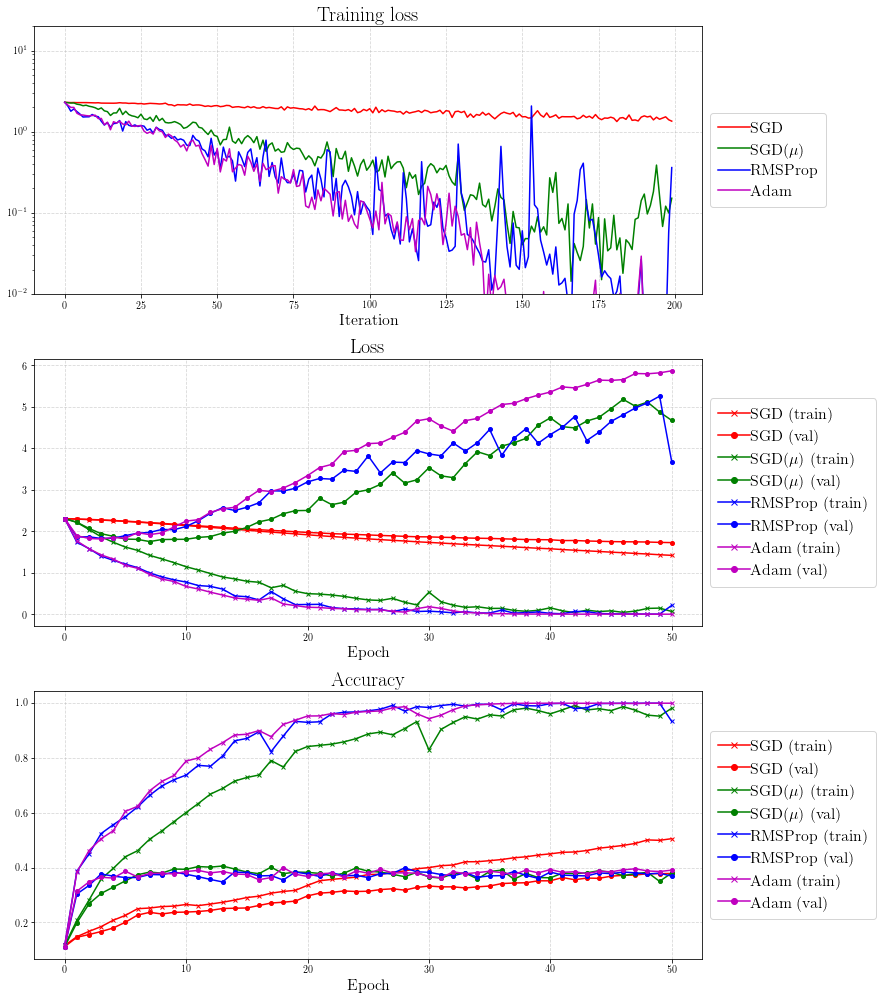

In [237]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
titles  = ['Training loss', 'Loss', 'Accuracy']
xlabels = ['Iteration',     'Epoch', 'Epoch']

for i in range(3):
    ax = axarr[i]
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel(xlabels[i], fontsize=16)
    
rule_map = {'sgd': r'SGD', 'sgd_momentum': r'SGD($\mu$)', 'rmsprop': 'RMSProp', 'adam': 'Adam'}
markers = {'train': 'x', 'val': 'o'}
colors  = {'sgd': 'r', 'sgd_momentum': 'g', 'rmsprop': 'b', 'adam': 'm'}

for update_rule in ['sgd', 'sgd_momentum', 'rmsprop', 'adam']:
    ax = axarr[0]
    loss_history = RESULTS[update_rule]['loss_history']
    ax.plot(loss_history[::10], '-', color=colors[update_rule], ms=2, label=rule_map[update_rule])
    ax.set_yscale('log')
    ax.set_ylim([1e-2, 20])
    
    ax = axarr[1]
    train_loss_history = RESULTS[update_rule]['train_loss_history']
    ax.plot(train_loss_history, marker=markers['train'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (train)')
    val_loss_history = RESULTS[update_rule]['val_loss_history']
    ax.plot(val_loss_history, marker=markers['val'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (val)')
    
    ax = axarr[2]
    train_acc_history = RESULTS[update_rule]['train_acc_history']
    ax.plot(train_acc_history, marker=markers['train'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (train)')
    val_acc_history = RESULTS[update_rule]['val_acc_history']
    ax.plot(val_acc_history, marker=markers['val'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (val)')

for i in range(3):
    axarr[i].legend(loc='center left', ncol=1, fontsize=16, bbox_to_anchor=(1.0, 0.5))
    axarr[i].grid(linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show()

<a id='comp_dropout'></a>
## X.X Dropout [[toc]](#toc)

<a id='comp_dropout_exp'></a>
### X.X.1 Regularization experiment [[toc](#toc)]
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [ ]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print('dropout =', dropout)

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every_iter=5)
    solver.train()
    solvers[dropout] = solver

In [ ]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}
markers = {0: 'o', 0.75: '^'}
colors = {0: 'r', 0.75: 'b'}

for dropout in dropout_choices:
    solver = solvers[dropout]
    
    ax = axarr[0]
    ax.plot(solver.loss_history, color=colors[dropout], label='p = {}'.format(dropout))

    ax = axarr[1]
    ax.plot(solver.train_loss_history, 'o', color=colors[dropout], label='train, p={}'.format(dropout), **plot_kwargs)
    ax.plot(solver.val_loss_history,   '^', color=colors[dropout], label='val, p={}'.format(dropout),   **plot_kwargs)

    ax = axarr[2]
    ax.plot(solver.train_acc_history, 'o', color=colors[dropout], label='train, p={}'.format(dropout), **plot_kwargs)
    ax.plot(solver.val_acc_history,   '^', color=colors[dropout], label='val, p={}'.format(dropout), **plot_kwargs)

ax = axarr[0]   
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[1]
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)
    
ax = axarr[2]
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=16)
    
plt.tight_layout()
plt.show()

#### Question
Explain what you see in this experiment. What does it suggest about dropout?
#### Answer

<a id='fcn_dropout'></a>
### 1.10.4 Fully-connected nets with Dropout [[toc](#toc)]

In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123, keep_seed=True) # keep_seed=True is critical here
    
    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

<a id='fcn_batchnorm_deep'></a>
## X.X Batch normalization for deep networks [[toc]](#toc)

<a id='fcn_batchnorm_conv'></a>
### X.X.X Convergence acceleration [[toc]](#toc)

Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [59]:
np.random.seed(231)
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'],
  'y_val':   data['y_val'],
}

solvers = {}
for use_batchnorm in [False, True]:
    layers = []
    for n_units in [100, 100, 100, 100, 100]:
        layers.append(Dense(n_units))
        if use_batchnorm: layers.append(BatchNormalization())
        layers.append(ReLU())
    layers.append(Dense(10))
    layers.append(SoftMax())
    sequential = Sequential(layers)
    model = Model(sequential, MulticlassLogLoss())
    solver = Solver(model, small_data, optim_config={'update_rule': 'sgd', 'learning_rate': 1e-3}, seed=1,
                   n_epochs=50, print_every_epoch=10, batch_size=50)
    print(model)
    solvers[use_batchnorm] = solver
    solver.train()
    print()

Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.12; val acc: 0.11, train loss: 2.298; val loss: 2.301
(Epoch 20/50) train acc: 0.17; val acc: 0.15, train loss: 2.292; val loss: 2.295
(Epoch 30/50) train acc: 0.21; val acc: 0.18, train loss: 2.282; val loss: 2.286
(Epoch 40/50) train acc: 0.23; val acc: 0.2, train loss: 2.268; val loss: 2.273
(Epoch 50/50) train acc: 0.24; val acc: 0.21, train loss: 2.246; val loss: 2.252

Dense(3072->100)->BatchNormalization->ReLU->Dense(100->100)->BatchNormalization->ReLU->Dense(100->100)->BatchNormalization->ReLU->Dense(100->100)->BatchNormalization->ReLU->Dense(100->100)->BatchNormalization->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.39; val acc: 0.27, train loss: 1.852; val loss: 2.08
(Epoch 20/50) train acc: 0.49; val acc: 0.3, train loss: 1.625; val loss: 1.988
(Epoch 30/50)

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

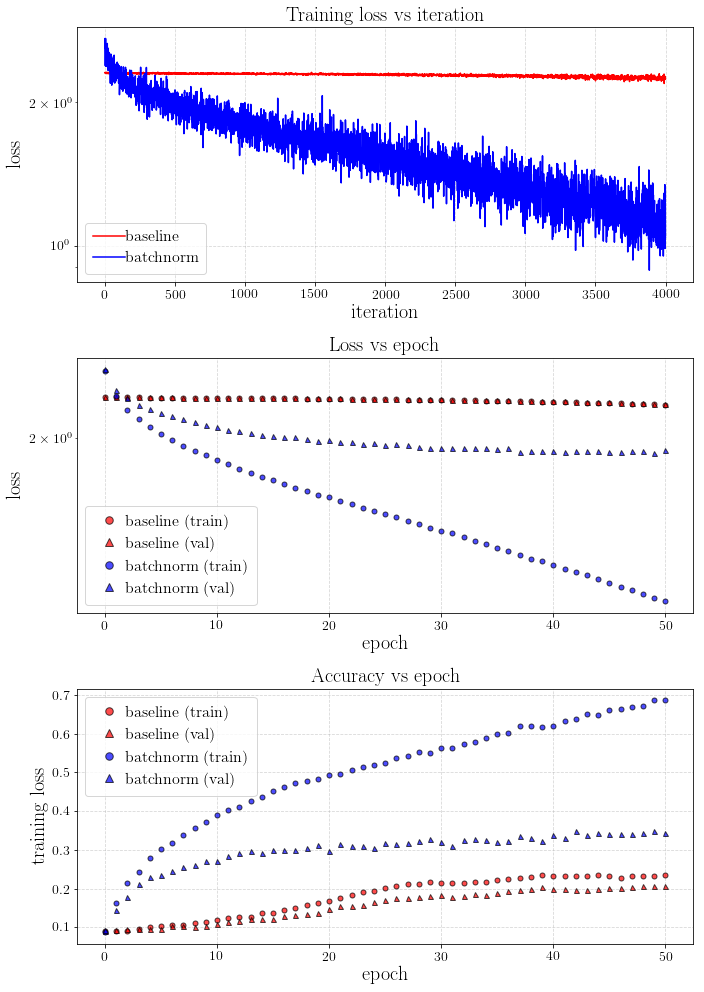

In [60]:
solver = solvers[False]
bn_solver = solvers[True]
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}

ax = axarr[0]
ax.plot(solver.loss_history, color='r', label='baseline')
ax.plot(bn_solver.loss_history, color='b', label='batchnorm')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[1]
ax.plot(solver.train_loss_history,    'o', color='r', label='baseline (train)', **plot_kwargs)
ax.plot(solver.val_loss_history,      '^', color='r', label='baseline (val)', **plot_kwargs)
ax.plot(bn_solver.train_loss_history, 'o', color='b', label='batchnorm (train)', **plot_kwargs)
ax.plot(bn_solver.val_loss_history,   '^', color='b', label='batchnorm (val)', **plot_kwargs)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', label='baseline (train)', **plot_kwargs)
ax.plot(solver.val_acc_history,   '^', color='r', label='baseline (val)', **plot_kwargs)
ax.plot(bn_solver.train_acc_history, 'o', color='b', label='batchnorm (train)', **plot_kwargs)
ax.plot(bn_solver.val_acc_history,   '^', color='b', label='batchnorm (val)', **plot_kwargs)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=16)

plt.tight_layout()
plt.show()

<a id='fcn_batchnorm_init'></a>
### X.X.X Batch normalization and initialization [[toc](#toc)]
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [64]:
np.random.seed(231)
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'],
  'y_val':   data['y_val'],
}

weight_scales = np.logspace(-4, 0, 20)
SOLVERS = {True: {}, False: {}}
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    for use_batchnorm in [False, True]:
        layers = []
        input_size = data['X_train'].shape[1]
        for n_units in [50, 50, 50, 50, 50, 50, 50]:
            W_init = np.random.normal(scale=weight_scale, size=(input_size, n_units))
            input_size = n_units
            layers.append(Dense(n_units, W_init=W_init))
            if use_batchnorm: layers.append(BatchNormalization())
            layers.append(ReLU())
        layers.append(Dense(10))
        layers.append(SoftMax())
        sequential = Sequential(layers)
        model = Model(sequential, MulticlassLogLoss())
        solver = Solver(model, small_data, optim_config={'update_rule': 'adam', 'learning_rate': 1e-3}, seed=1,
                       n_epochs=50, print_every_epoch=10, batch_size=50)
        print(model)
        solver.train()
        SOLVERS[use_batchnorm][weight_scale] = solver
        print()

Running weight scale 1 / 20
Dense(3072->50)->ReLU->Dense(50->50)->ReLU->Dense(50->50)->ReLU->Dense(50->50)->ReLU->Dense(50->50)->ReLU->Dense(50->50)->ReLU->Dense(50->50)->ReLU->Dense(50->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.11; val acc: 0.1, train loss: 2.299; val loss: 2.307
(Epoch 20/50) train acc: 0.11; val acc: 0.1, train loss: 2.299; val loss: 2.309
(Epoch 30/50) train acc: 0.11; val acc: 0.1, train loss: 2.299; val loss: 2.307
(Epoch 40/50) train acc: 0.1; val acc: 0.1, train loss: 2.299; val loss: 2.306
(Epoch 50/50) train acc: 0.11; val acc: 0.1, train loss: 2.299; val loss: 2.307

Dense(3072->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.48; val acc: 0.3, t

(Epoch 10/50) train acc: 0.19; val acc: 0.14, train loss: 2.108; val loss: 2.279
(Epoch 20/50) train acc: 0.22; val acc: 0.15, train loss: 1.76; val loss: 2.443
(Epoch 30/50) train acc: 0.34; val acc: 0.18, train loss: 1.534; val loss: 3.109
(Epoch 40/50) train acc: 0.4; val acc: 0.22, train loss: 1.356; val loss: 3.675
(Epoch 50/50) train acc: 0.53; val acc: 0.2, train loss: 1.12; val loss: 5.174

Dense(3072->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.5; val acc: 0.3, train loss: 1.453; val loss: 2.105
(Epoch 20/50) train acc: 0.69; val acc: 0.32, train loss: 0.9035; val loss: 2.409
(Epoch 30/50) train acc: 0.78; val acc: 0.31, train loss: 0.6689; val loss: 2.775
(Epoch 40/50) train ac

(Epoch 10/50) train acc: 0.25; val acc: 0.19, train loss: 1.87; val loss: 2.182
(Epoch 20/50) train acc: 0.41; val acc: 0.23, train loss: 1.39; val loss: 2.767
(Epoch 30/50) train acc: 0.61; val acc: 0.24, train loss: 0.9587; val loss: 4.018
(Epoch 40/50) train acc: 0.74; val acc: 0.25, train loss: 0.6577; val loss: 5.563
(Epoch 50/50) train acc: 0.84; val acc: 0.24, train loss: 0.4355; val loss: 7.22

Dense(3072->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.61; val acc: 0.29, train loss: 1.149; val loss: 2.266
(Epoch 20/50) train acc: 0.8; val acc: 0.3, train loss: 0.6257; val loss: 2.705
(Epoch 30/50) train acc: 0.85; val acc: 0.3, train loss: 0.4686; val loss: 3.169
(Epoch 40/50) train

(Epoch 10/50) train acc: 0.1; val acc: 0.097, train loss: 37.16; val loss: 37.43
(Epoch 20/50) train acc: 0.12; val acc: 0.11, train loss: 36.51; val loss: 36.89
(Epoch 30/50) train acc: 0.12; val acc: 0.11, train loss: 36.51; val loss: 36.89
(Epoch 40/50) train acc: 0.12; val acc: 0.11, train loss: 36.51; val loss: 36.89
(Epoch 50/50) train acc: 0.12; val acc: 0.11, train loss: 36.51; val loss: 36.89

Dense(3072->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->50)->BatchNormalization->ReLU->Dense(50->10)->SoftMax->[MulticlassLogLoss]
(Epoch 10/50) train acc: 0.4; val acc: 0.19, train loss: 1.821; val loss: 2.244
(Epoch 20/50) train acc: 0.56; val acc: 0.25, train loss: 1.358; val loss: 2.277
(Epoch 30/50) train acc: 0.69; val acc: 0.26, train loss: 0.9767; val loss: 2.494
(Epoch 40/50) trai

In [68]:
# Plot results of weight scale experiment
bn_solvers = SOLVERS[True]
solvers = SOLVERS[False]

best_train_accs,  bn_best_train_accs  = [], []
best_val_accs,    bn_best_val_accs    = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.ylim([0, 4])
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 15)
plt.tight_layout()
plt.show()

TypeError: 'Solver' object is not subscriptable

#### Question:
Describe the results of this experiment, and try to give a reason why the experiment gave the results that it did.
#### Answer:

In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `ml/neural_network/cs231n/second/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

<a id='fcn_final'></a>
## X.X Final model [[toc]](#toc)

<a id='fcn_good'></a>
#### 1.10.5.1 Train model [[toc](#toc)]
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 2))
cnet.add(SoftMax())

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

<a id='cnn'></a>
# 3. Convolutional Networks  [[toc](#toc)]
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.